## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print(ratings.shape)
print(movies.shape)

(100004, 4)
(9125, 3)


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [6]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [7]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [8]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [9]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.817998   0.80661   
    1      0.766508   0.775769                                  
    2      0.61013    0.763987                                  



[0.76398706]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [10]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [11]:
preds = learn.predict()

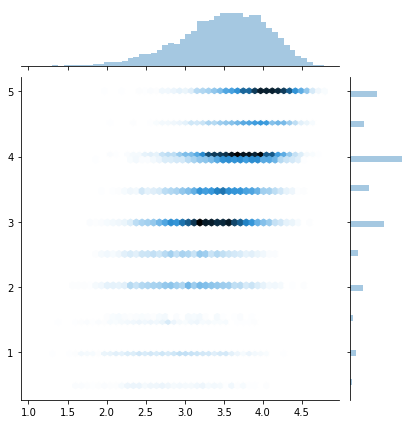

In [12]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [ ]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [ ]:
m=learn.model; m.cuda()

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [ ]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [ ]:
print(movie_bias.shape)
movie_bias

In [ ]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [ ]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

In [ ]:
sorted(movie_ratings, key=itemgetter(0))[:15]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [ ]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [ ]:
movie_pca.shape

In [ ]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

In [ ]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [ ]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

In [ ]:
a*b

In [ ]:
(a*b).sum(1)

In [ ]:
torch.mm(a, b)
b1 = torch.transpose(b, 0, 1)
(a*b1).sum(1)

In [ ]:
class DotProduct(nn.Module):
    def forward(self, u, m): 
        return torch.mm(u, m)
        return (u*m).sum(1)

In [ ]:
model=DotProduct()

In [ ]:
model(a,b)

### Dot product model

In [ ]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [ ]:
tt = torch.autograd.Variable(torch.randn((5,10)))

In [ ]:
tt1 = torch.squeeze(tt, 0)
# torch.transpose(tt1, 0, 1)
tt1.transpose(0, 1)

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies, n_embeddings):
        super().__init__()
        self.u = nn.Embedding(n_users, n_embeddings)
        self.m = nn.Embedding(n_movies, n_embeddings)
        
#         print(torch.mean(self.u.weight))
        # Initialize weights to be positive?
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
#         print(torch.mean(self.u.weight))
        
    def forward(self, cats, conts):
        # When testing on non cuda
#         users = torch.autograd.Variable(cats[:, 0].cpu())
#         movies = torch.autograd.Variable(cats[:, 1].cpu())
        users = cats[:, 0]
        movies = cats[:, 1]
        emb_u = self.u(users)
        emb_m = self.m(movies)
        return (emb_u*emb_m).sum(1)

In [ ]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [ ]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [ ]:
a = EmbeddingDot(n_users, n_movies, 10)

In [ ]:
a

In [ ]:
# first_batch = next(iter(data.trn_dl))
# model = EmbeddingDot(n_users, n_movies, n_factors)
# model(first_batch[0], first_batch[1])

In [ ]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies, 10).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
??fit

In [ ]:
??F.mse_loss

In [ ]:
??torch.nn.MSELoss

In [ ]:
fit(model, data, 3, opt, F.mse_loss)


In [ ]:
set_lrs(opt, 0.01)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

### Bias

In [ ]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

In [ ]:
def get_emb(ni,nf):
    return None

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies, n_factors):
        super().__init__()
        self.u = torch.nn.Embedding(n_users, n_factors)
        self.m = torch.nn.Embedding(n_movies, n_factors)
        self.u_b = torch.nn.Embedding(n_users, 1)
        self.m_b = torch.nn.Embedding(n_movies, 1)
        
    def forward(self, cats, conts):
        users = cats[:, 0]
        movies = cats[:, 1]
#         users = torch.autograd.Variable(users.cpu())
#         movies = torch.autograd.Variable(movies.cpu())
        u_emb = self.u(users)
        m_emb = self.m(movies)
        s = (u_emb * m_emb).sum(1)
        return s + self.u_b(users).squeeze() + self.m_b(movies).squeeze()

In [ ]:
# first_batch = next(iter(data.trn_dl))
# model = EmbeddingDotBias(n_users, n_movies, n_factors)
# model(first_batch[0], first_batch[1])

In [ ]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items, n_factors).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

In [ ]:
set_lrs(opt, 1e-2)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

### Mini net

In [ ]:
torch.cat((torch.randn((2,10)), torch.randn((2,10))), 1).size()

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        self.u = torch.nn.Embedding(n_users, n_factors)
        self.m = torch.nn.Embedding(n_movies, n_factors)
#         self.u_b = torch.nn.Embedding(n_users, 1)
#         self.m_b = torch.nn.Embedding(n_movies, 1)
        self.d1 = torch.nn.Dropout(p1)
        self.fc1 = torch.nn.Linear(n_factors*2, 1000)
        self.fc2 = torch.nn.Linear(1000, 1)
        self.d2 = torch.nn.Dropout(p1)
        
    def forward(self, cats, conts):
        # need to add dropout
        users = cats[:, 0]
        movies = cats[:, 1]
#         users = torch.autograd.Variable(users.cpu())
#         movies = torch.autograd.Variable(movies.cpu())
        u_emb = self.u(users)
        m_emb = self.m(movies)
        
        um_cat = torch.cat((u_emb, m_emb), 1)
        x = self.d1(um_cat)
        x = F.relu(self.fc1(x))
        x = self.d2(x)
        x = F.sigmoid(self.fc2(x))
        return x * 5
#         s = (u_emb * m_emb).sum(1)
#         return s + self.u_b(users).squeeze() + self.m_b(movies).squeeze()

In [ ]:
# first_batch = next(iter(data.trn_dl))
# model = EmbeddingNet(n_users, n_movies)
# model(first_batch[0], first_batch[1])

In [ ]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)